# Install Packages

In [ ]:
!conda install -c conda-forge opencv -y
!pip install facenet-pytorch
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Import Packages

In [2]:
import os
import requests
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Download Dataset

## DeepfakeTIMIT: Deepfakes
Any publication (eg. conference paper, journal article, technical report, book chapter, etc) resulting from the usage of DeepfakeTIMIT must cite the following paper:

    P. Korshunov and S. Marcel,
    DeepFakes: a New Threat to Face Recognition? Assessment and Detection.
    arXiv https://arxiv.org/abs/1812.08685 and Idiap Research Report (http://publications.idiap.ch/index.php/publications/show/3988)

In [46]:
!wget --no-check-certificate -O DeepfakeTIMIT.tar.gz "https://zenodo.org/records/4068245/files/DeepfakeTIMIT.tar.gz?download=1"
!tar -xf DeepfakeTIMIT.tar.gz
!rm DeepfakeTIMIT.tar.gz
!wget --no-check-certificate "https://my.pcloud.com/publink/show?code=XZLGvd7ZI9LjgIy7iOLzXBG5RNJzGFQzhTRy"

--2025-02-05 23:27:26--  https://my.pcloud.com/publink/show?code=XZLGvd7ZI9LjgIy7iOLzXBG5RNJzGFQzhTRy
Resolving my.pcloud.com (my.pcloud.com)... 45.131.244.10, 45.131.247.13, 45.131.247.15, ...
Connecting to my.pcloud.com (my.pcloud.com)|45.131.244.10|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 302 Found
Location: https://u.pcloud.link/publink/show?code=XZLGvd7ZI9LjgIy7iOLzXBG5RNJzGFQzhTRy [following]
--2025-02-05 23:27:26--  https://u.pcloud.link/publink/show?code=XZLGvd7ZI9LjgIy7iOLzXBG5RNJzGFQzhTRy
Resolving u.pcloud.link (u.pcloud.link)... 74.120.8.115, 74.120.9.94, 74.120.8.110, ...
Connecting to u.pcloud.link (u.pcloud.link)|74.120.8.115|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 404 Not Found
2025-02-05 23:27:27 ERROR 404: Not Found.



## VidTIMIT Audio-Video Dataset: True Images
The VidTIMIT dataset is Copyright © 2001 Conrad Sanderson.

Distribution and research usage of this dataset is permitted under the following conditions:

    1. This notice is left intact and not modified in any way.
    2. The dataset is provided as is. There is no warranty as to the fitness for any particular purpose.
    3. The author of the dataset is not responsible for any direct or indirect losses resulting from the use of the dataset.
    4. Any publication (eg. conference paper, journal article, technical report, book chapter, etc) resulting from the usage of VidTIMIT must cite the following paper:
        C. Sanderson and B.C. Lovell
        Multi-Region Probabilistic Histograms for Robust and Scalable Identity Inference.
        Lecture Notes in Computer Science (LNCS), Vol. 5558, pp. 199-208, 2009.

In [7]:
# List of file names
file_names = [
    "fadg0", "faks0", "fcft0", "fcmh0", "fdac1", "fdrd1", "fedw0", "felc0", "fjas0",    "fjem0", "fjre0", "fjwb0", "fkms0", "fram1",
    "mccs0", "mcem0", "mdab0", "mdbb0", "mdld0", "mgwt0", "mjar0", "mjsw0", "mmdb1", "mmdm2", "mpdf0", "mpgl0", "mrcz0", "mrgg0", "mrjo0",
    "msjs1", "mstk0", "mwbt0"
]

# Base URL
base_url = "https://zenodo.org/record/158963/files/{}.zip"

# Download folder
download_folder = "VidTIMIT"
os.makedirs(download_folder, exist_ok=True)

# Function to download files
def download_file(file_name):
    url = base_url.format(file_name)
    local_filename = os.path.join(download_folder, f"{file_name}.zip")
    
    print(f"Downloading {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(local_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded: {local_filename}")
    else:
        print(f"Failed to download {url}, Status Code: {response.status_code}")

# Download each file one at a time
for file_name in file_names:
    download_file(file_name)

# Function to extract and delete zip files
def extract_and_delete_zip(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(download_folder)
        print(f"Extracted: {zip_path}")
        os.remove(zip_path)
        print(f"Deleted: {zip_path}")
    except zipfile.BadZipFile:
        print(f"Error: {zip_path} is not a valid zip file.")

# Process all zip files in the folder
for file in os.listdir(download_folder):
    if file.endswith(".zip"):
        zip_path = os.path.join(download_folder, file)
        extract_and_delete_zip(zip_path)

print("All zip files extracted and deleted.")

Downloaded: VidTIMIT/mjar0.zip


# Setup Device

In [6]:
# Check for GPU
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")
print("CUDA Available:", torch.cuda.is_available())
print(f"Using device: {DEVICE}")
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

CUDA Available: True
Using device: cpu
GPU Name: Tesla V100-SXM2-16GB


# Dataset Pipeline

## Subset
We can only take half of the dataset because the deepfakes are made for both people. Therefore we have to take 1 isntance of each pair.

In [3]:
def remove_duplicate_pairs(input_dict):
    """
    Removes duplicate key-value pairs by ensuring each value appears only once in the dictionary.
    Keeps the first occurrence and removes the reverse mapping.
    """
    cleaned_dict = {}
    seen = set()  # Track seen values

    for key, value in input_dict.items():
        if key not in seen and value not in seen:  # Ensure key and value are unique
            cleaned_dict[key] = value
            seen.add(key)
            seen.add(value)  # Mark both as used

    return cleaned_dict
    
def get_label(path):
    paths = [f.split(".")[0] for f in os.listdir(path) if f.endswith(".avi")]
    label = paths[0].split("-")[-1]
    return label

def get_paths(path):
    # helper to list the dataset path
    samples = [f for f in os.listdir(path) if not f.endswith(".dircksum")]
    samples = {sample:get_label(path+sample) for sample in samples}
    samples = {sample:samples[sample] for sample in samples}
    return samples

def get_label(path):
    paths = [f.split(".")[0] for f in os.listdir(path) if f.endswith(".avi")]
    label = paths[0].split("-")[-1]
    return label

dataset_keys = remove_duplicate_pairs(get_paths("DeepfakeTIMIT/higher_quality/"))

## Train and Label
We will use Sesson 1 of the recordings for each person and use session 3 as the label.

Dataset function is incomplete

In [4]:
# PyTorch Dataset for DeepfakeTIMIT and VidTIMIT
class DeepfakeTIMITDataset(Dataset):
    def __init__(self, deepfake_root, label_root, dataset_keys, transform=None, frame_interval=1):
        self.deepfake_root = deepfake_root
        self.vid_root = vid_root
        self.transform = transform if transform else transforms.ToTensor()
        self.frame_interval = frame_interval
        
        # Collect all deepfake video paths
        self.video_paths = ["DeepfakeTIMIT/higher_quality/fadg0/sa1-video-fram1.avi"]
        self.true_frame_paths = ["VidTIMIT/fadg0/video/sa1/"]
        
        for person in os.listdir(deepfake_root):
            deepfake_person_path = os.path.join(deepfake_root, person)
            vid_person_path = os.path.join(vid_root, person)
            
            if not os.path.isdir(deepfake_person_path) or not os.path.isdir(vid_person_path):
                continue
            
            for video_file in os.listdir(deepfake_person_path):
                if video_file.endswith(".avi"):
                    video_path = os.path.join(deepfake_person_path, video_file)
                    video_name = os.path.splitext(video_file)[0]
                    
                    true_frame_dir = os.path.join(vid_person_path, video_name)
                    if os.path.isdir(true_frame_dir):
                        self.video_paths.append(video_path)
                        self.true_frame_paths.append(true_frame_dir)

    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        true_frame_dir = self.true_frame_paths[idx]
        
        cap = cv2.VideoCapture(video_path)
        frames = []
        count = 0
        
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            if count % self.frame_interval == 0:
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_pil = Image.fromarray(frame_rgb)
                frame_tensor = self.transform(frame_pil)
                frames.append(frame_tensor)
            
            count += 1
        
        cap.release()
        
        # Load ground truth frames
        true_frames = []
        sorted_frame_files = sorted(os.listdir(true_frame_dir))
        
        for frame_file in sorted_frame_files[::self.frame_interval]:
            frame_path = os.path.join(true_frame_dir, frame_file)
            true_frame = Image.open(frame_path).convert("RGB")
            true_frame_tensor = self.transform(true_frame)
            true_frames.append(true_frame_tensor)
        
        return torch.stack(frames), torch.stack(true_frames)

# Example Usage
deepfake_root = "DeepfakeTIMIT/higher_quality"
vid_root = "VidTIMIT"
dataset = DeepfakeTIMITDataset(deepfake_root, vid_root, dataset_keys)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

for fake_frames, true_frames in dataloader:
    print("Fake Video Frames Shape:", fake_frames.shape)
    print("True Frames Shape:", true_frames.shape)
    break

Fake Video Frames Shape: torch.Size([1, 119, 3, 384, 512])
True Frames Shape: torch.Size([1, 119, 3, 384, 512])


# Model

In [17]:
# Load Face Detector (MTCNN) and Feature Extractor (FaceNet)
# mtcnn = MTCNN(keep_all=True), device=DEVICE)
# face_encoder = InceptionResnetV1(pretrained='vggface2').eval().to(DEVICE)

# Define Siamese Network with Temporal Modeling of Facial Movements
class SiameseNetworkTemporal(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2):
        super(SiameseNetworkTemporal, self).__init__()
        # self.mtcnn = MTCNN(keep_all=True)
        self.resnet = models.resnet18(models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity()  # Remove final classification layer
        
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256)
        )
    
    def forward(self, x1_seq, x2_seq):
        batch_size, seq_len, c, h, w = x1_seq.shape  # Extract dimensions
        # x1_seq = self.mtcnn(x1_seq)
        # x2_seq = self.mtcnn(x2_seq)
        x1_seq = x1_seq.view(batch_size * seq_len, c, h, w)  # Flatten batch & sequence
        x2_seq = x2_seq.view(batch_size * seq_len, c, h, w)
        
        f1_seq = self.resnet(x1_seq).view(batch_size, seq_len, -1)  # Extract features
        f2_seq = self.resnet(x2_seq).view(batch_size, seq_len, -1)

        f1_seq, _ = self.lstm(f1_seq)  # Pass through LSTM for facial movement analysis
        f2_seq, _ = self.lstm(f2_seq)
        
        f1 = torch.mean(f1_seq, dim=1)  # Average hidden states for temporal aggregation
        f2 = torch.mean(f2_seq, dim=1)

        f1, f2 = self.fc(f1), self.fc(f2)  # Fully connected layers
        
        similarity = torch.cosine_similarity(f1, f2)
        return similarity

# Initialize Model with Temporal Movement Analysis
model = SiameseNetworkTemporal().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)

# Test Environemt for Model

In [18]:
# Define dummy input tensors to simulate a batch of video frames (batch_size=2, seq_len=5, channels=3, height=224, width=224)
dummy_x1 = torch.randn(2, 5, 3, 224, 224).to(DEVICE)
dummy_x2 = torch.randn(2, 5, 3, 224, 224).to(DEVICE)

# Check model output
try:
    output = model(dummy_x1, dummy_x2)
    print("Model Output:", output)
    print("Output Shape:", output.shape)
except Exception as e:
    print("Error:", e)


torch.Size([2, 512])
Model Output: tensor([1.0000, 1.0000], grad_fn=<SumBackward1>)
Output Shape: torch.Size([2])


In [ ]:
# Training Function
def train_model(dataloader, model, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for fake_frames, true_frames in dataloader:
            fake_frames, true_frames = fake_frames.to(DEVICE), true_frames.to(DEVICE)
            optimizer.zero_grad()
            similarity = model(fake_frames, true_frames)
            print(similarity.shape)
            loss = criterion(similarity, torch.ones_like(similarity))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader)}")

# Inference Function
def inference(model, fake_video_frames, true_video_frames):
    model.eval()
    with torch.no_grad():
        fake_video_frames, true_video_frames = fake_video_frames.to(DEVICE), true_video_frames.to(DEVICE)
        similarity = model(fake_video_frames, true_video_frames)
        return similarity.cpu().numpy()

# Load data
deepfake_root = "DeepfakeTIMIT/higher_quality"
vid_root = "VidTIMIT"
dataset = DeepfakeTIMITDataset(deepfake_root, vid_root, dataset_keys)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Train the model
train_model(dataloader, model, criterion, optimizer, num_epochs=5)

# inference
for fake_frames, true_frames in dataloader:
    similarity_scores = inference(model, fake_frames, true_frames)
    print("Similarity Scores:", similarity_scores)
    break

Loaded 528 frames from VidTIMIT/fram1/video/head3/


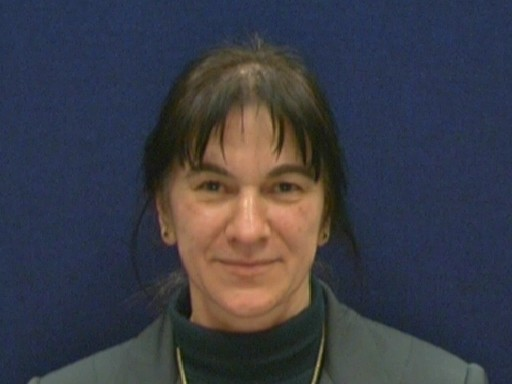

In [119]:
# Path to the folder containing frames
frames_folder = "VidTIMIT/fram1/video/head3/"

# Get all JPEG files sorted by filename (frame order)
frame_files = sorted([f for f in os.listdir(frames_folder)])

# Read frames one by one
frames = []
for frame_file in frame_files:
    frame_path = os.path.join(frames_folder, frame_file)
    frame = Image.open(frame_path).convert("RGB")  # Convert to RGB
    frames.append(frame)

print(f"Loaded {len(frames)} frames from {frames_folder}")
frames[0]

# Dataset Previews

##  Preview VidTIMIT

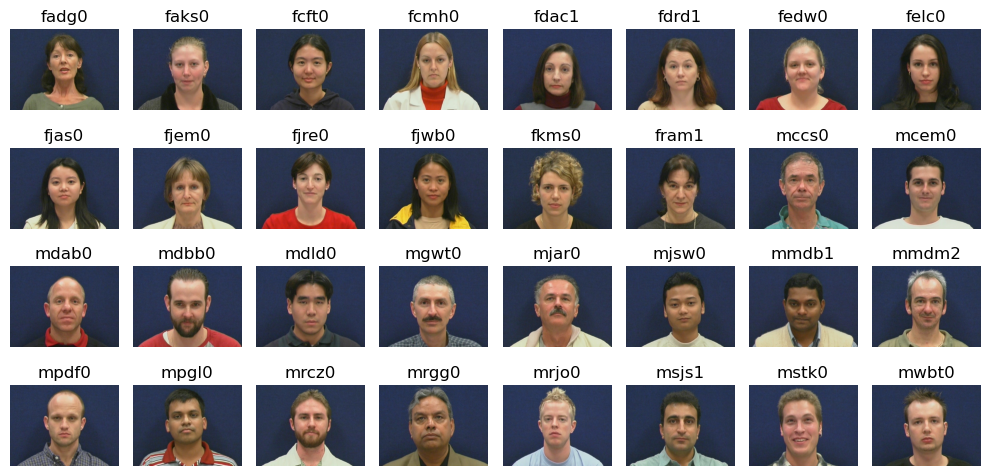

In [204]:
# List of file paths
file_paths = ["VidTIMIT/" + x + "/video/head/" for x in file_names]

# Function to load and display a matrix of images with file paths
def display_image_matrix(file_paths, cols=8):
    rows = (len(file_paths) + cols - 1) // cols  # Calculate rows based on number of paths
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

    for i, file_path in enumerate(file_paths):
        frame_files = sorted([f for f in os.listdir(file_path)])[0]
        if not frame_files:
            continue

        frame_path = os.path.join(file_path, frame_files)  # Select first frame
        image = Image.open(frame_path).convert("RGB")

        ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
        ax.imshow(image)
        ax.set_title(os.path.basename(file_names[i]))
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Display the images in a matrix format
display_image_matrix(file_paths)


## Preview DeepfakeTIMIT

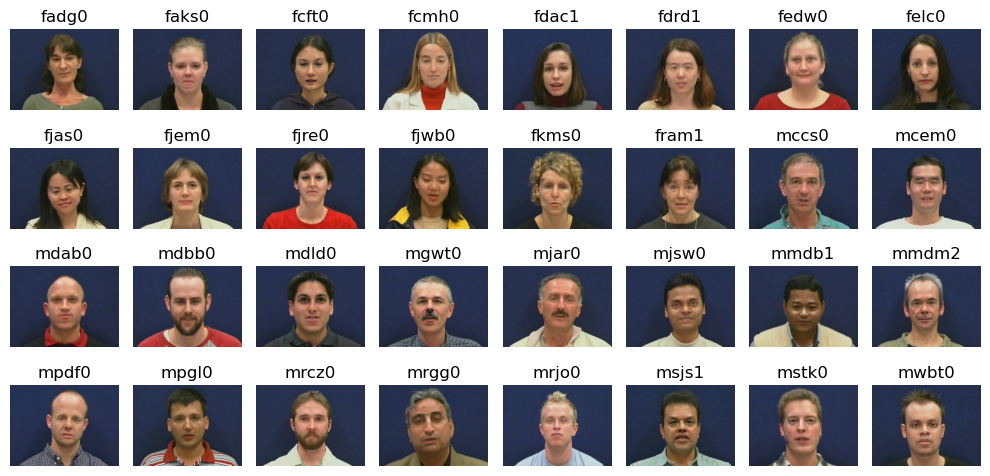

In [205]:
# List of file paths
file_paths = ["DeepfakeTIMIT/higher_quality/" + x + "/" for x in file_names]

# Function to load and display a matrix of images with file paths
def display_image_matrix(file_paths, cols=8):
    rows = (len(file_paths) + cols - 1) // cols  # Calculate rows based on number of paths
    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

    for i, path in enumerate(file_paths):
        file_path = sorted([f for f in os.listdir(path)])[1]
        cap = cv2.VideoCapture(path+file_path)
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
        
            # Convert BGR to RGB for deep learning models
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(frame_rgb)  # Convert to PIL Image
            
            # Now you can apply transformations for PyTorch models
        
            cap.release()

            ax = axes[i // cols, i % cols] if rows > 1 else axes[i % cols]
            ax.imshow(image)
            ax.set_title(os.path.basename(file_names[i]))
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Display the images in a matrix format
display_image_matrix(file_paths)